### Load and install necessary packages

In [1]:
#!pip install --user spacy
#!python -m spacy download en

In [2]:
%matplotlib inline
import numpy as np
import collections
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import spacy
import warnings
import gensim
from textblob import TextBlob
from IPython.core.debugger import Tracer
from gingerit.gingerit import GingerIt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
warnings.filterwarnings('ignore')

In [3]:
#!pip install --user gensim pyLDAvis wordlcoud

In [4]:
#nltk.download('wordnet')
#nltk.download('stopwords')

### Import helper functions from scripts

In [5]:
import sys
sys.path.insert(0, '../scripts/')
from preprocess_modular import clean_preprocess,read_prepare_data

### Load Complaints Dataset

In [6]:
keywords_df = read_prepare_data(data_path=os.environ['DSX_PROJECT_DIR']+
                       '/datasets/Complaints_All_2018_Consolidated_Final_For_upload.csv')

keywords_df.head(3)

ConcernDescription  \
0  Unclaimed Monies  - ANZ Account - $1,978,74. I...   
1  Customer is unable to pay his business loans s...   
2  I am writing to express our grave concern abou...   

                            IssueDescription  \
0                    unclaimed money request   
1  customer is wanting legal actions stopped   
2                 Loan application declined.   

                               ResolutionDescription  \
0  CA - 5 September 2017 - Feedback noted. Estate...   
1  Customer Advocate- confirmed with customer tha...   
2  23/08/2017 - Requested further information fro...   

                                      keyword_corpus  
0  Unclaimed Monies  - ANZ Account - $1,978,74. I...  
1  Customer is unable to pay his business loans s...  
2  I am writing to express our grave concern abou...

In [7]:
#keywords_df['keyword_corpus'][0]

# NLP Pre-processing

### Load NLTK stop words and custom stop words list

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [9]:
stop_words = set(stop_words)

In [10]:
#!pip install --user gensim
from gensim.parsing.preprocessing import STOPWORDS
custom_stopwords = ['anz','account','customer','card','bank','complaint']
#custom_stopwords = ['anz','account','customer','bank','complaint']
my_stop_words = STOPWORDS.union(set(custom_stopwords))

### Preprocessing of Data

In [11]:
from gensim.parsing import preprocessing as pp

pp_list = [
    lambda x: x.lower(),
    pp.strip_tags,
    pp.strip_multiple_whitespaces,
    pp.strip_punctuation,
    pp.strip_short,
    pp.remove_stopwords,
    pp.strip_numeric
          ]

def tokenizer(line):
    """ Applies the following steps in sequence:
        Converts to lower case,
        Strips tags (HTML and others),
        Strips multiple whitespaces,
        Strips punctuation,
        Strips short words(min lenght = 3),
        --------------------------
        :param line: a document
        
        Returns a list of tokens"""
    
    tokens = pp.preprocess_string(line, filters=pp_list)
    return tokens

def remove_custom_stopwords(line,custom_stopwords):
    result = [val for i,val in line if val not in custom_stopwords]
    return result

            

In [12]:
def count_null_percategory(df):
    null_columns=df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum()
    #print(keywords_df[keywords_df.isnull().any(axis=1)][null_columns].head(1))

In [13]:
count_null_percategory(keywords_df)

ConcernDescription        26
IssueDescription         147
ResolutionDescription    571
dtype: int64

In [14]:
len(keywords_df['keyword_corpus'])

34747

### Apply it on our dataset

In [15]:
%%time

train_texts = []
try:
    for index,line in enumerate(keywords_df['keyword_corpus']):
        tokens = tokenizer(line)
        tokenz = [val for i, val in enumerate(tokens) if val not in custom_stopwords]
        #tokens = remove_custom_stopwords(line,custom_stopwords)
        train_texts.append(tokenz)
        
except Exception as e:
    print(index,e)

CPU times: user 19.6 s, sys: 240 ms, total: 19.8 s
Wall time: 19.9 s


In [16]:
len(train_texts)

34747

In [17]:
#train_texts[0]

In [18]:
keywords_df['tokens'] = train_texts
keywords_df.head(5)

ConcernDescription  \
0  Unclaimed Monies  - ANZ Account - $1,978,74. I...   
1  Customer is unable to pay his business loans s...   
2  I am writing to express our grave concern abou...   
3  Customer request we return his documents as it...   
4  Customer is disappointed with collections call...   

                            IssueDescription  \
0                    unclaimed money request   
1  customer is wanting legal actions stopped   
2                 Loan application declined.   
3                      Credit limit increase   
4                          Collections calls   

                               ResolutionDescription  \
0  CA - 5 September 2017 - Feedback noted. Estate...   
1  Customer Advocate- confirmed with customer tha...   
2  23/08/2017 - Requested further information fro...   
3  28 August 2017 - Response issued advising that...   
4  CA - 1 September 2017- Response to customer an...   

                                      keyword_corpus  \
0  Unclaimed Monies  - ANZ Account - $1,978,74. I...   
1  Customer is unable to pay his business loans s...   
2  I am writing to express our grave concern abou...   
3  Customer request we return his documents as it...   
4  Customer is disappointed with collections call...   

                                              tokens  
0  [unclaimed, monies, emailing, london, sydney, ...  
1  [unable, pay, business, loans, expected, compe...  
2  [writing, express, grave, concern, processing,...  
3  [request, return, documents, sensitive, inform...  
4  [disappointed, collections, calls, receiving, ...

## Visualize word cloud of all tokens

In [19]:
unigram_counter = collections.Counter(x for xs in train_texts for x in set(xs))

for stop_word in stop_words:
    if stop_word in unigram_counter:
        unigram_counter.pop(stop_word)

unigram_counter.most_common(10)

[('advised', 18228),
 ('apologised', 13541),
 ('credit', 13489),
 ('happy', 9996),
 ('branch', 9579),
 ('sent', 9521),
 ('feedback', 9097),
 ('closed', 9057),
 ('received', 8735),
 ('inconvenience', 8443)]

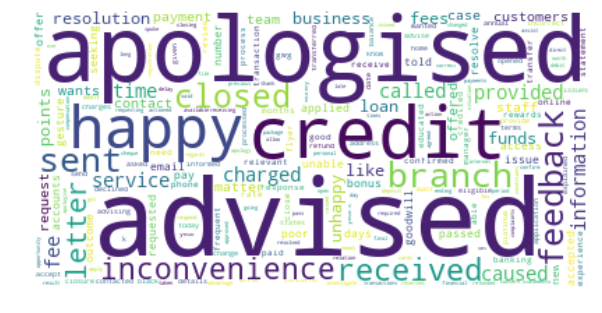

In [20]:
# For Mac
# wc = WordCloud(font_path="/Library/Fonts/DIN Condensed Bold.ttf", background_color='white', mask=image_mask, random_state=42)
wc = WordCloud(background_color='white', random_state=42)

plt.figure(figsize=(10, 8))
plt.imshow(wc.fit_words(unigram_counter), interpolation='bilinear')
plt.axis("off")
plt.savefig('../datasets/total_wordcloud.png')
plt.show()

### Spellchecker and Slang Removal

In [21]:
slang_hash = {'monies':'money','cust':'customer'}

def replace_slangs(lists):
    result = [slang_hash[word] if word in slang_hash else word for word in lists]
    return result

In [22]:
def autocorrect(df):
    autocorrect =[]
    for each in train_text_final:
        parser = GingerIt()
        for line in each:
            tweet=parser.parse(line)
            autocorrect.append(lemmatizer.lemmatize(tweet['corrections'][0]['text'],pos='v'))
            #df['tokens'].apply(lambda x: str(TextBlob(x).correct()))
    return autocorrect
    

In [23]:
#print(replace_slangs(['required','responsed','monies']))

In [24]:
def clean():
    result = []
    for each in train_texts:
        inter_res = replace_slangs(each)
        result.append(inter_res)
    return result    

## Phrase Modeling  and Lematization of the Corpus

Identify the most common trigrams and bigrams based on the complaints data

In [25]:
def get_phrases(lists):
    bigram = gensim.models.Phrases(lists)

    bigram_phraser = gensim.models.phrases.Phraser(bigram)
    tokens_ = bigram_phraser[lists]
    trigram = gensim.models.Phrases(tokens_)
    trigram_phraser = gensim.models.phrases.Phraser(trigram)
    return trigram_phraser,bigram_phraser

def lemmatize_process(lists,phrased):
    bigram_phraser,trigram_phraser = get_phrases(lists)
    for each in train_text_final:
        res= bigram_phraser[each]
        res = trigram_phraser[res]
        phrased.append([lemmatizer.lemmatize(word, pos='v') for word in res])
    return phrased
        
        
    
    
    

In [ ]:
train_text_final = clean()
phrased=[]
phrased = lemmatize_process(train_text_final,phrased)

In [ ]:
# get_phraser = get_phrases(train_text_final)
len(phrased)

In [ ]:
keywords_df['finalized_tokens'] = phrased
keywords_df.head()

### Remove duplicate tokens to create corpus dictionary

In [ ]:
def remove_duplicate_tokens(test):
    for each in test:
        train_texts_corp =[]
        train_texts_c.append(list(dict.fromkeys(each)))
    return train_texts_corp

In [ ]:
# %matplotlib inline
# from nltk import FreqDist
# words = trigram_phraser[]
# fd =FreqDist(words)
# fd.plot(30,cumulative=False,title="Word Frequency")

### The Topic Model 

In [40]:
from gensim.corpora import Dictionary

# Create a dictionary(vocab) with all tokens
dictionary = Dictionary(phrased)

# Filter tokens which appear less than 5 times,
# and those which appear more than 50% of the time.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert our documents to bag-of-words
corpus = [dictionary.doc2bow(text) for text in phrased]

In [61]:
%%time

from gensim.models import LdaModel

# Set random seed to reproduce results
np.random.seed(42)

NUM_TOPICS = 36

# Caution: the below parameters will take a long time to run
# First run it with default parameters
passes = 30
iterations = 500
eval_every = 50

# Increase the number of passes to get better results. But it'll takes more time
ldamodel = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary,
                    passes=passes,
                   iterations=iterations,
                   eval_every=eval_every)

CPU times: user 14min 58s, sys: 36 ms, total: 14min 58s
Wall time: 14min 59s


In [62]:
ldamodel

In [ ]:
list(dictionary.iteritems())

In [ ]:
#!pip install --user pyLDAvis

In [64]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

prepared_viz = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

In [65]:
import pyLDAvis

pyLDAvis.display(prepared_viz)

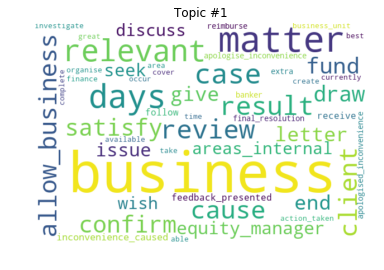

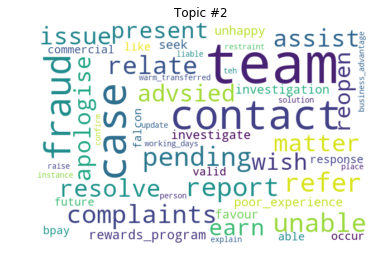

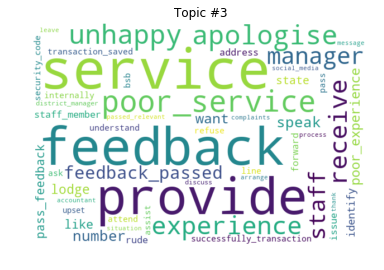

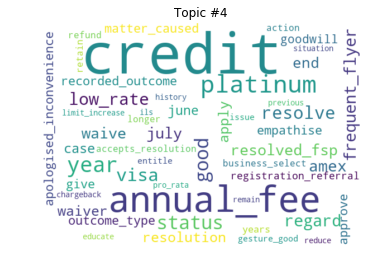

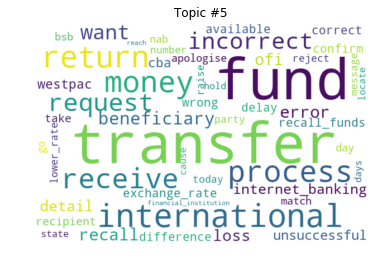

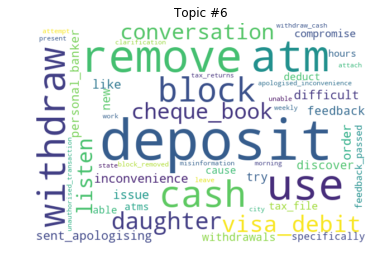

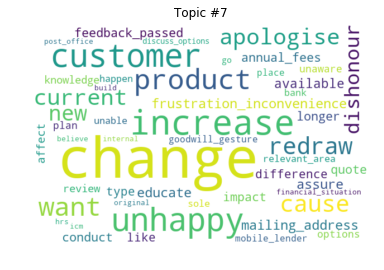

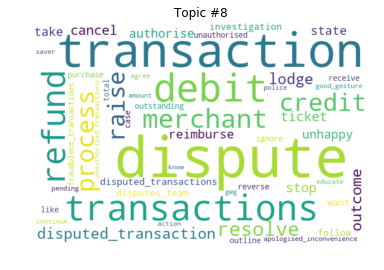

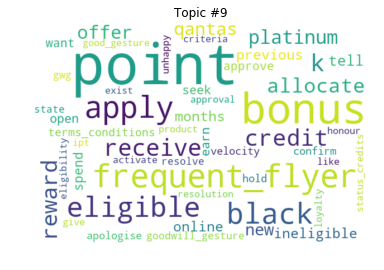

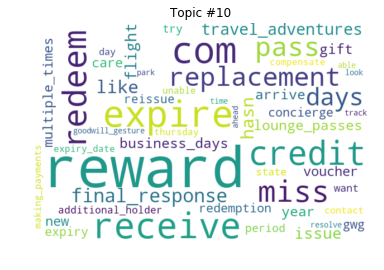

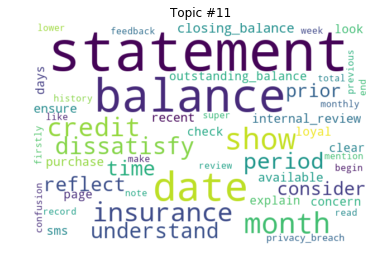

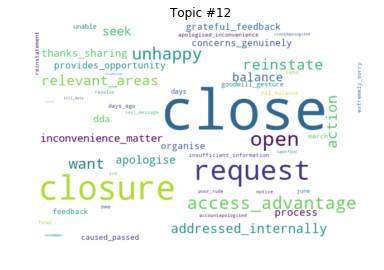

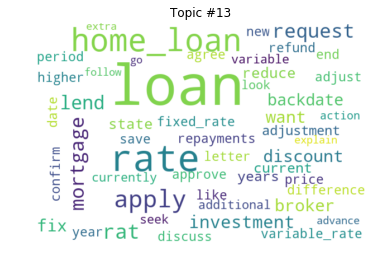

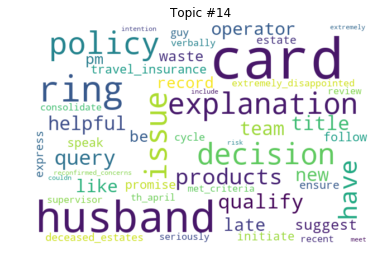

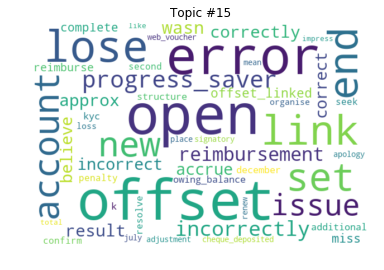

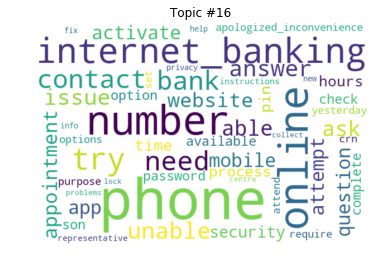

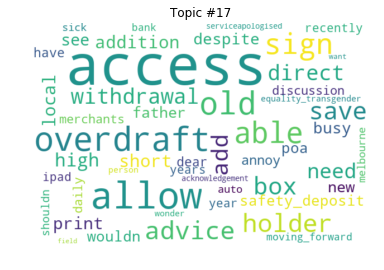

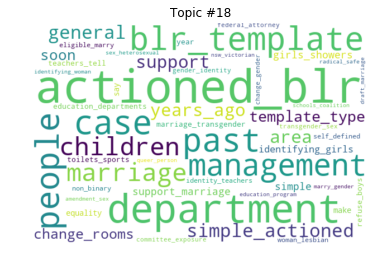

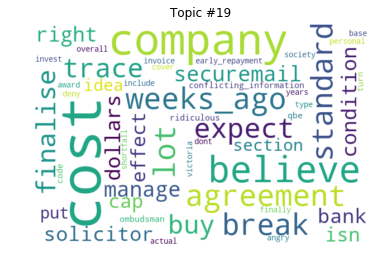

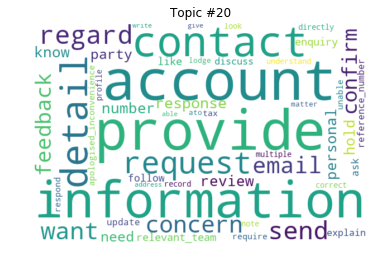

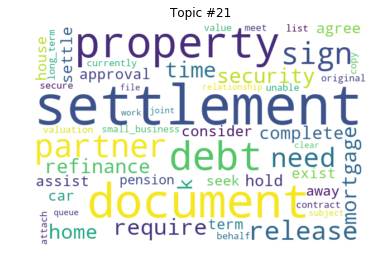

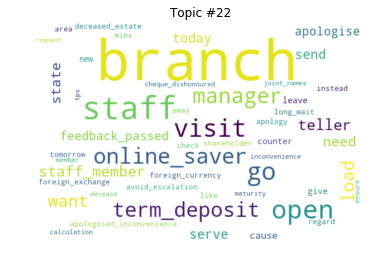

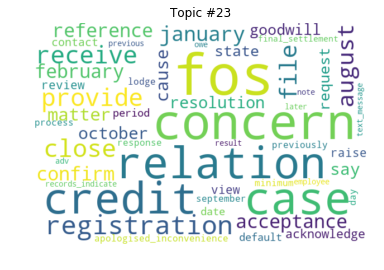

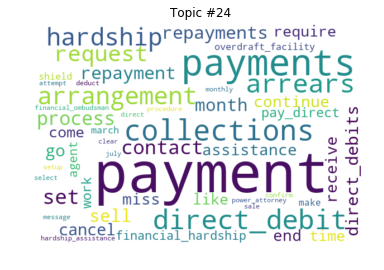

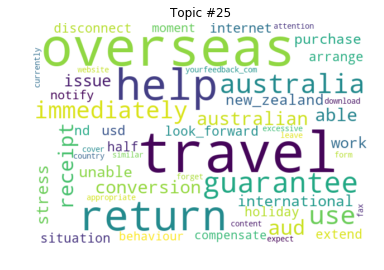

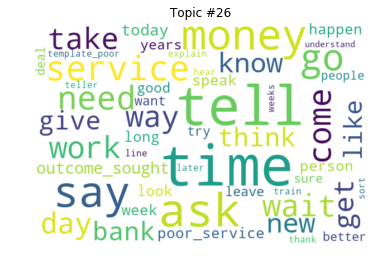

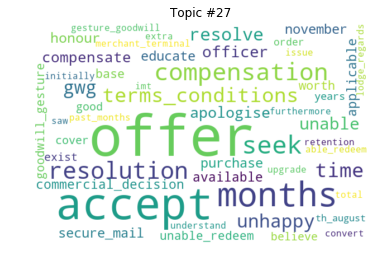

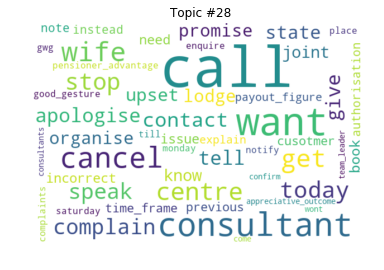

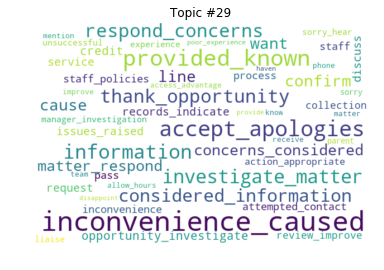

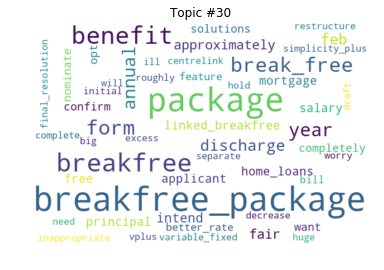

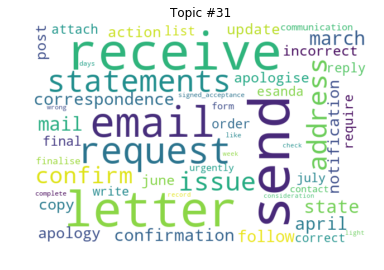

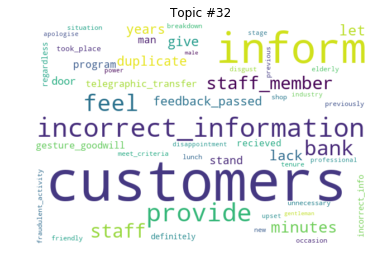

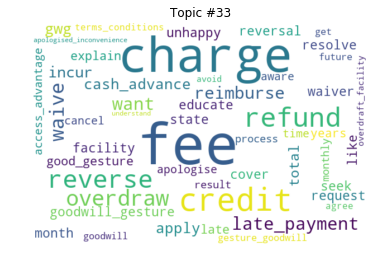

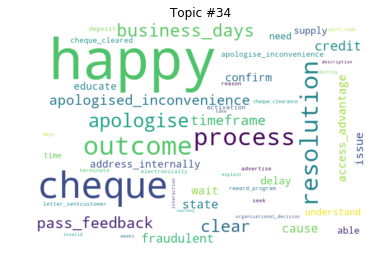

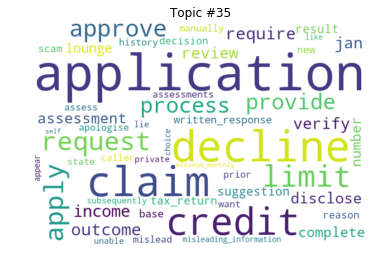

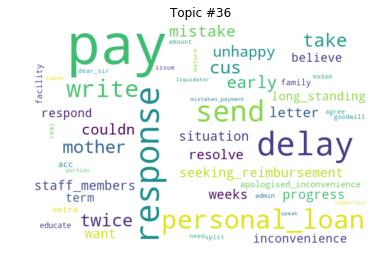

In [60]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white', max_font_size=100, width=600, height=400)

for t in range(ldamodel.num_topics):
    plt.figure(figsize=(6, 5))
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 50))), interpolation='bilinear')
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    plt.show()

### Topic Distribution

In [ ]:
from pprint import pprint
pprint(ldamodel.print_topics())

### Compute Model Perplexity

In [76]:

print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Perplexity:  -9.32485534011559


### Compute Coherence Score

In [77]:

from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel, texts=phrased, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41762974711510886


In [ ]:
# phrased = []
# for each in train_text_final:
#     phrased.append(get_phraser[each])

# keywords_df['finalized_tokens'] = phrased

In [ ]:
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")

# def process_texts(tokens):
#     """Removes stop words, Stemming,
#        Lemmatization assuming verb"""
    
#     tokens = [token for token in tokens if token not in stop_words and custom_stopwords]
#     tokens = bigram_phraser[tokens]
#     tokens = trigram_phraser[tokens]
# #     tokens = [stemmer.stem(token) for token in tokens]
#     tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
#     return tokens

In [ ]:
# %matplotlib inline
# from nltk import FreqDist
# words = trigram_phraser[]
# fd =FreqDist(words)
# fd.plot(30,cumulative=False,title="Word Frequency")

In [ ]:
#bigram_phraser([[u'account', u'holder', u'of', u'new', u'york', u'was', u'there']])

In [ ]:
# from gensim.models import Phrases
# documents = ["the mayor of new york was there", "machine learning can be useful sometimes","new york mayor was present"]
# sentence_stream = [doc.split(" ") for doc in documents]
# bigram = Phrases(sentence_stream, min_count=1, threshold=3)
# sent = [u'account', u'holder', u'of', u'new', u'york', u'credit', u'card']
# print(bigram[sent])

In [ ]:
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")

# def process_texts(tokens):
#     """Removes stop words, Stemming,
#        Lemmatization assuming verb"""
    
#     tokens = [token for token in tokens if token not in stop_words]
#     tokens = bigram_phraser[tokens]
#     tokens = trigram_phraser[tokens]
# #     tokens = [stemmer.stem(token) for token in tokens]
#     tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
#     return tokens

In [ ]:
# %%time

# final_texts = []

# for line in train_texts:
#     final_texts.append(process_texts(line))

In [ ]:
# keywords_df['tokens'] = train_texts
# #keywords_df['tokens'][0]
# #set(keywords_df['tokens'][0])

In [ ]:
# from gingerit.gingerit import GingerIt
# parser = GingerIt()
# line="responses"
# tweet=parser.parse(line)
# lemmatizer.lemmatize(tweet['corrections'][0]['text'],pos='v')